In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Лабораторная работа 3.

### *Деревья решений. Ансамбли решающих деревьев.*

1. [Выбрать подходящую таблицу данных. Построить и визуализировать дерево решений.](#Пункт-1)

2. [Применить метод градиентного бустинга. Вычислить значимость переменных. Выдать список построенных деревьев.](#Пункт-2)

3. [Построить зависимость качества решения (на обучении и скользящем контроле) от числа вершин дерева.](##Пункт-3)

4. [Для метода градиентного бустинга построить зависимость качества решения (на обучении и скользящем контроле) от числа деревьев.
Для разной глубины дерева нужно построить несколько зависимостей качества от числа деревьев, чтобы найти оптимальную комбинацию этих параметров. ](##Пункт-4)

5. [Выполнить предыдущий пункт для случайного леса. ](##Пункт-5)


# Пункт 1

In [3]:
# dataset = datasets.load_wine()
dataset = datasets.load_iris()

xs = dataset.data
ys = dataset.target

xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2, random_state=42)

#### Данные в датасете

In [4]:
dataset_class_counts  = np.unique(dataset.target, return_counts=True)[1]
dataset_class_counts_str = '\n\t'.join([f'{x}: {y} ({y/len(dataset.data)*100:.2f}%)' for x, y in zip(dataset.target_names, dataset_class_counts)])

print(f"Метки классов: {', '.join(dataset.target_names)}")
print(f"Кол-во обьектов: {len(dataset.data)}")
print(f"Кол-во обьектов по классам: \n\t{dataset_class_counts_str}")

Метки классов: setosa, versicolor, virginica
Кол-во обьектов: 150
Кол-во обьектов по классам: 
	setosa: 50 (33.33%)
	versicolor: 50 (33.33%)
	virginica: 50 (33.33%)


d:\Programming\TeorStat\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


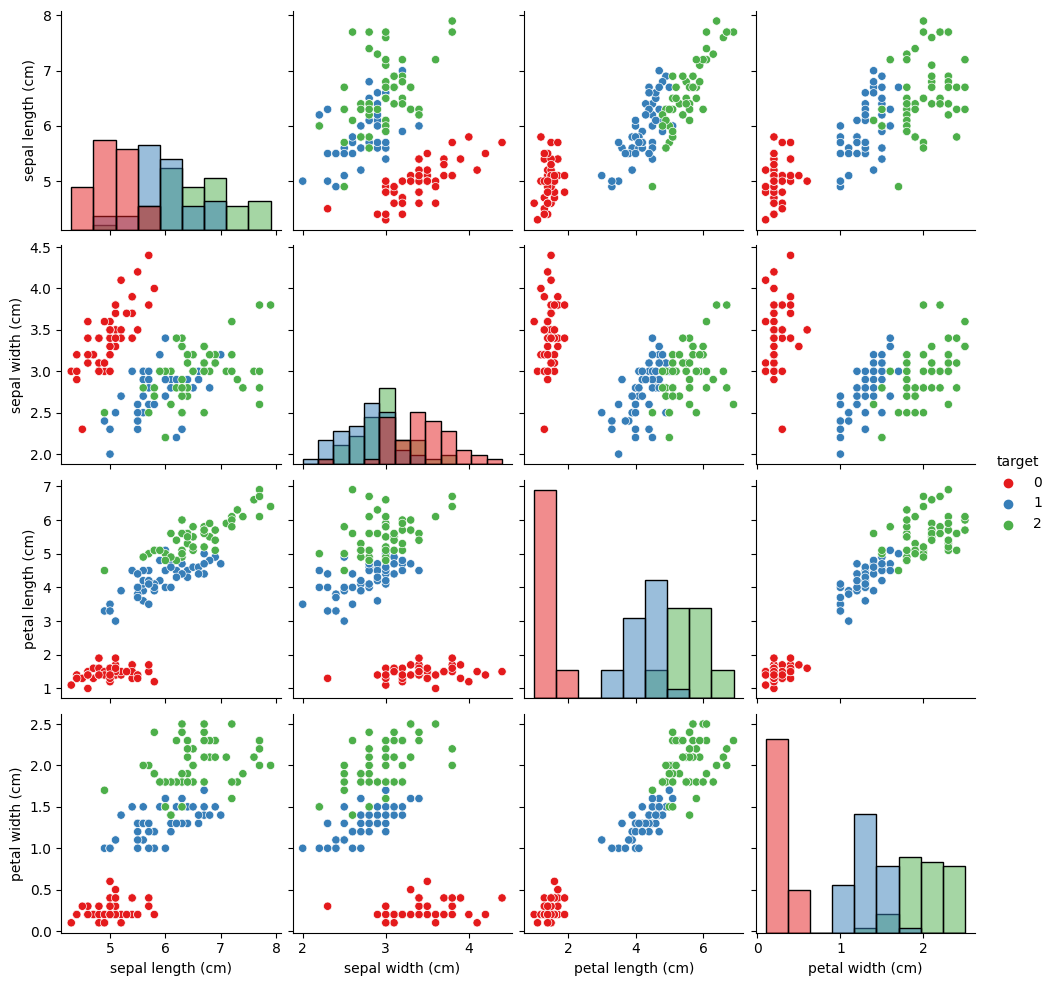

In [5]:
sns_showcase = pd.DataFrame(xs, columns=dataset.feature_names)
sns_showcase['target'] = ys

sns.pairplot(sns_showcase, hue='target', diag_kind='hist', palette='Set1')
plt.show()

In [6]:
clf = DecisionTreeClassifier()
clf.fit(xs_train, ys_train)

DecisionTreeClassifier()

#### Метрики

In [7]:
ys_pred = clf.predict(xs_test)

print(classification_report(ys_test, ys_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



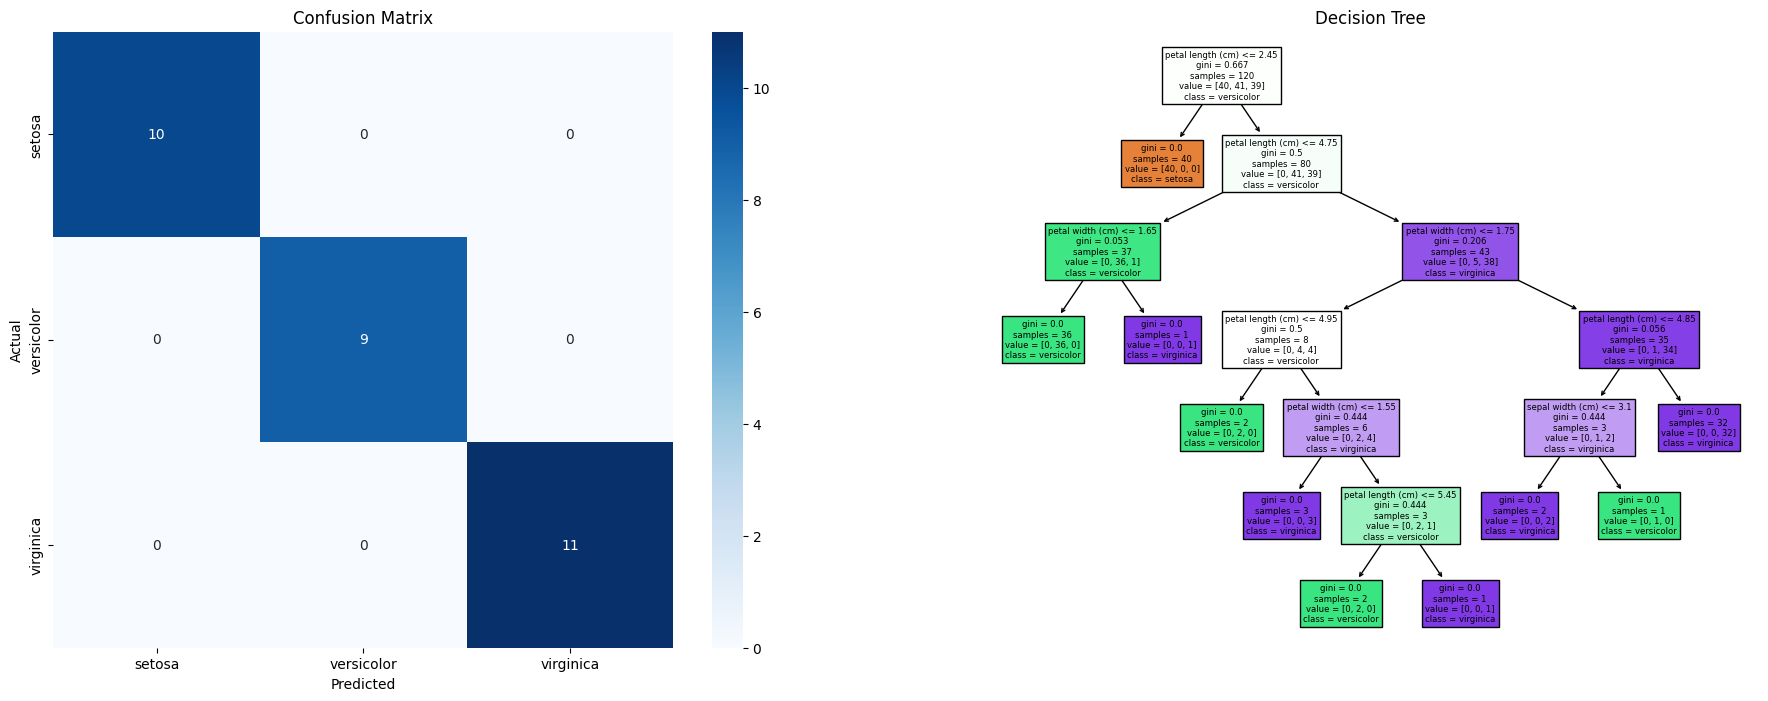

In [8]:
plt.figure(figsize=(22, 8))

plt.subplot(121)
sns.heatmap(confusion_matrix(ys_test, ys_pred), annot=True, fmt="d", cmap="Blues", xticklabels=dataset.target_names, yticklabels=dataset.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.subplot(122)
tree.plot_tree(clf, feature_names=dataset.feature_names, class_names=list(dataset.target_names), filled=True)
plt.title("Decision Tree")
plt.show()

# Пункт 2

In [ ]:
# визуализация дерева на плоскости признаков по парам

In [9]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_model.fit(xs_train, ys_train)

GradientBoostingClassifier(random_state=42)

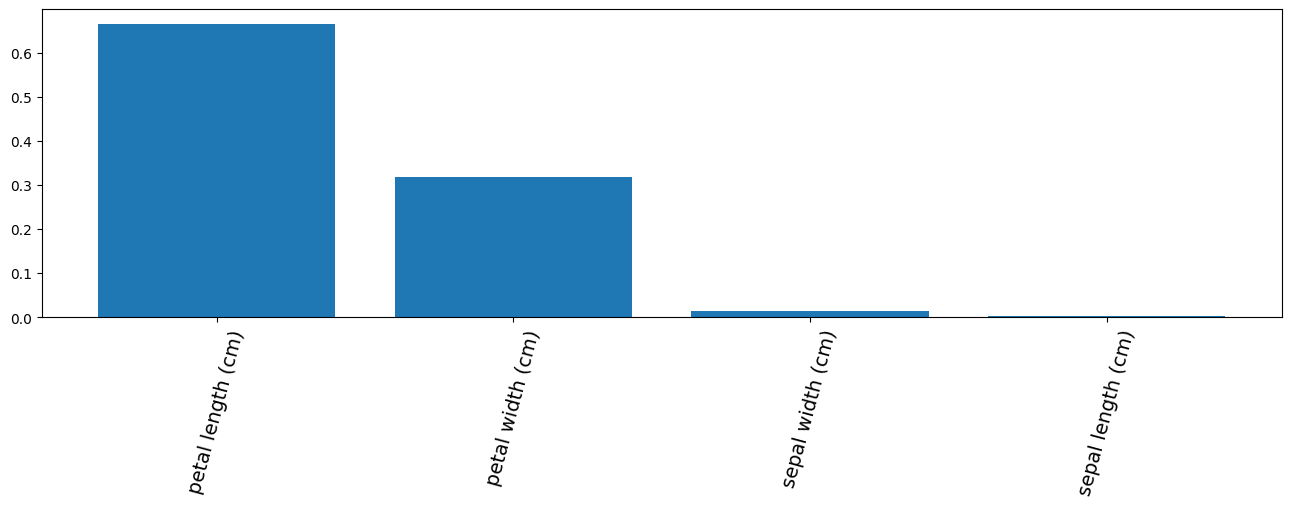

In [10]:
feature_importance = gb_model.feature_importances_
feature_importance_dict = dict(zip(dataset.feature_names, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

variables, importance = zip(*sorted_feature_importance)
fig = plt.figure(figsize=(16, 4))
plt.bar(variables, importance)
plt.xticks(fontsize=14,rotation=75)
plt.show()

In [11]:
depths = []
node_counts = []
leaf_counts = []

for base_model_index, trees in enumerate(gb_model.estimators_):
    for tree_number, tree in enumerate(trees):
        depths.append(tree.tree_.max_depth)
        node_counts.append(tree.tree_.node_count)
        leaves = np.unique(tree.apply(xs_train))
        leaf_counts.append(len(leaves))

average_depth = np.mean(depths)
average_node_count = np.mean(node_counts)
average_leaf_count = np.mean(leaf_counts)

print(f"Средняя глубина деревьев: {average_depth}")
print(f"Среднее количество узлов: {average_node_count}")
print(f"Среднее количество листьев: {average_leaf_count}")


Средняя глубина деревьев: 2.993333333333333
Среднее количество узлов: 12.546666666666667
Среднее количество листьев: 6.773333333333333


# Пункт 3

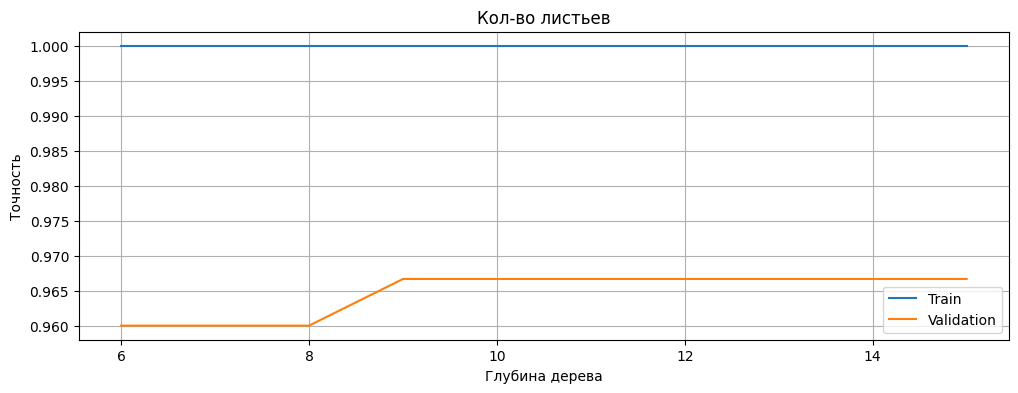

In [17]:
cv = StratifiedKFold(n_splits=5)

leafs = range(6, 16)

train_scores = []
valid_scores = []

for leaf in leafs:
    
    train_sc = []
    valid_sc = []

    for train, test in cv.split(xs, ys):
        gb_model = GradientBoostingClassifier(max_depth=5, random_state=42, max_leaf_nodes=leaf)
        gb_model.fit(xs[train], ys[train])

        pred_train = gb_model.predict(xs[train])
        pred_test  = gb_model.predict(xs[test])

        train_sc.append(accuracy_score(ys[train], pred_train))
        valid_sc.append(accuracy_score(ys[test], pred_test))
    
    train_scores.append(np.mean(train_sc))
    valid_scores.append(np.mean(valid_sc))

plt.figure(figsize=(12, 4))
plt.plot(leafs, train_scores, label='Train')
plt.plot(leafs, valid_scores, label='Validation')
plt.xlabel('Глубина дерева')
plt.ylabel('Точность')
plt.title('Кол-во листьев')
plt.grid(True)
plt.legend()
plt.show()

# Lbcrhbnyst ghbpyfrb ytghfdbkmyj dbpefkbpdfjhl

# Пункт 4

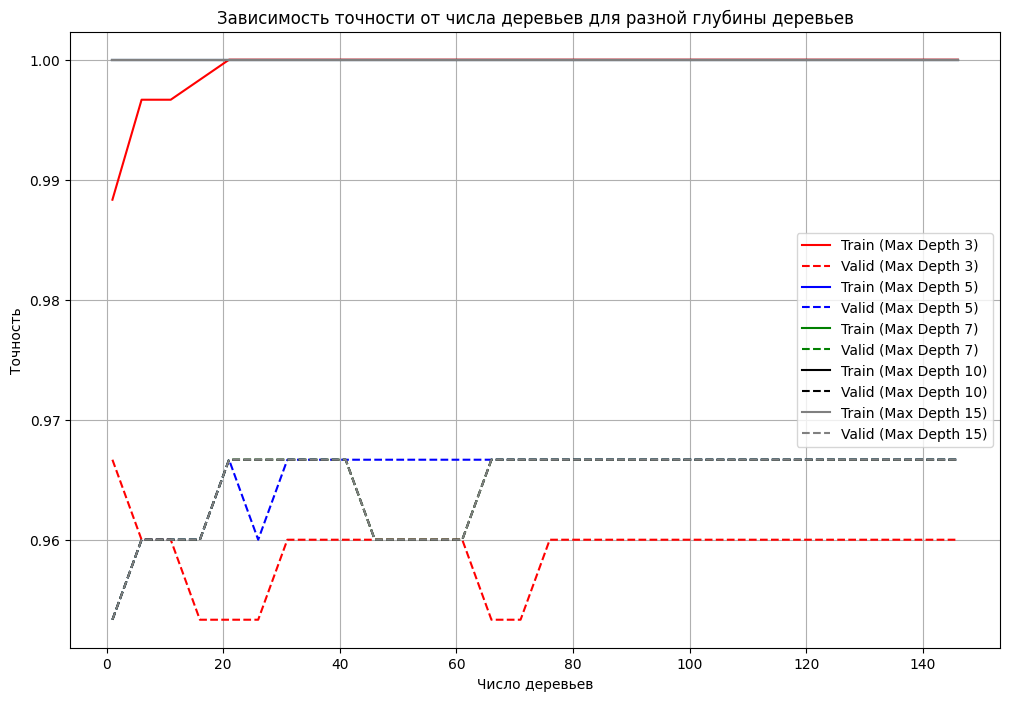

In [20]:
n_estimators_values = np.arange(1, 150, 5)
max_depth_values = [3, 5, 7, 10, 15]

colors = ['red', 'blue', 'green', 'black', 'grey']

train_scores = []
valid_scores = []

for max_depth in max_depth_values:
    train_scores_depth = []
    valid_scores_depth = []

    for n_estimators in n_estimators_values:
        train_sc = []
        valid_sc = []
        
        for train, test in cv.split(xs, ys):
            gb_model = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
            gb_model.fit(xs[train], ys[train])

            pred_train = gb_model.predict(xs[train])
            pred_test  = gb_model.predict(xs[test])

            train_sc.append(accuracy_score(ys[train], pred_train))
            valid_sc.append(accuracy_score(ys[test], pred_test))
        
        train_scores_depth.append(np.mean(train_sc))
        valid_scores_depth.append(np.mean(valid_sc))
    
    train_scores.append(train_scores_depth)
    valid_scores.append(valid_scores_depth)

plt.figure(figsize=(12, 8))

for i, (max_depth, color) in enumerate(zip(max_depth_values, colors)):
    plt.plot(n_estimators_values, train_scores[i], label=f'Train (Max Depth {max_depth})', color=color)
    plt.plot(n_estimators_values, valid_scores[i], label=f'Valid (Max Depth {max_depth})', linestyle='dashed', color=color)

plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа деревьев для разной глубины деревьев')
plt.grid(True)
plt.legend()
plt.show()

# Пункт 5

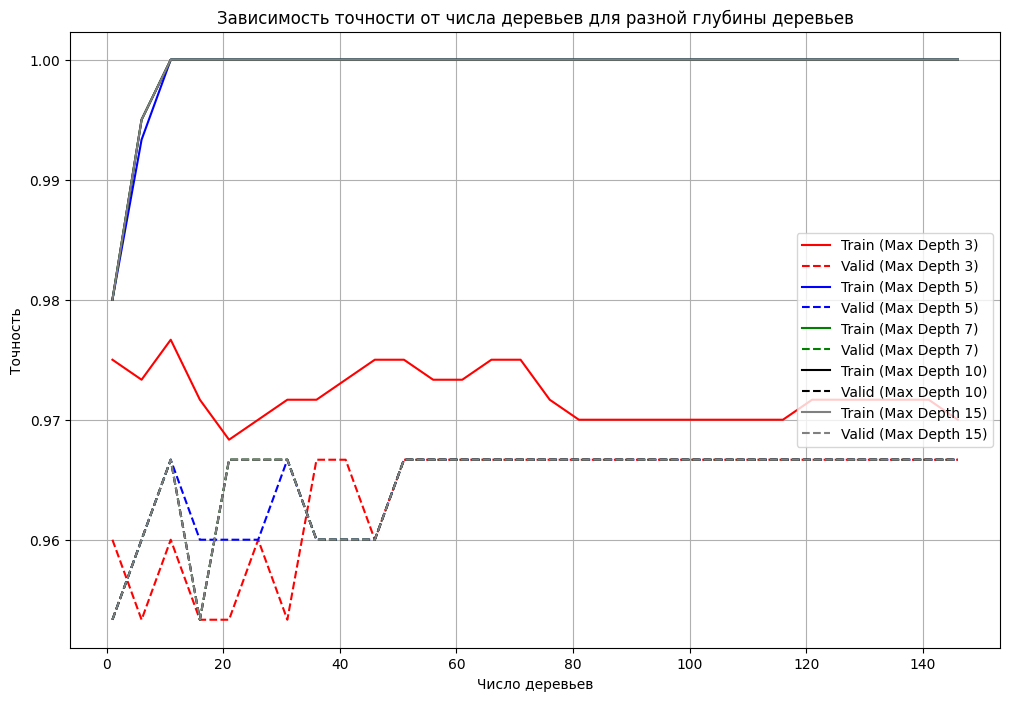

In [21]:
train_scores = []
valid_scores = []

for max_depth in max_depth_values:
    train_scores_depth = []
    valid_scores_depth = []

    for n_estimators in n_estimators_values:
        train_sc = []
        valid_sc = []

        for train, test in cv.split(xs, ys):
            gb_model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
            gb_model.fit(xs[train], ys[train])

            pred_train = gb_model.predict(xs[train])
            pred_test  = gb_model.predict(xs[test])

            train_sc.append(accuracy_score(ys[train], pred_train))
            valid_sc.append(accuracy_score(ys[test], pred_test))

        train_scores_depth.append(np.mean(train_sc))
        valid_scores_depth.append(np.mean(valid_sc))
    
    train_scores.append(train_scores_depth)
    valid_scores.append(valid_scores_depth)

plt.figure(figsize=(12, 8))

for i, (max_depth, color) in enumerate(zip(max_depth_values, colors)):
    plt.plot(n_estimators_values, train_scores[i], label=f'Train (Max Depth {max_depth})', color=color)
    plt.plot(n_estimators_values, valid_scores[i], label=f'Valid (Max Depth {max_depth})', linestyle='dashed', color=color)

plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа деревьев для разной глубины деревьев')
plt.grid(True)
plt.legend()
plt.show()